# COVID19DB PROJECT (www.covid19db.org): covid19 - confirmed cases, administrative division for Italy


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [157]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)

cur = conn.cursor()
cur.execute("""SELECT i.* FROM
                (SELECT max(date) AS date, countrycode, adm_area_1
                FROM infections WHERE source=%(source)s
                GROUP BY countrycode, adm_area_1 ) AS recent_data
              INNER JOIN infections AS i
              ON i.date=recent_data.date 
              AND i.countrycode = recent_data.countrycode
              AND i.adm_area_1 = recent_data.adm_area_1
              AND i.adm_area_1 <> ''
              AND (i.adm_area_2 IS NULL OR i.adm_area_2 = '')
              AND i.source=%(source)s
              ORDER by i.confirmed DESC
            """, {'source': 'ITA_PCDM'})
covid19_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

In [158]:
covid19_data[["date", "adm_area_1", "confirmed"]].head()

,date,adm_area_1,confirmed
0,2020-04-04,Lombardia,37116
1,2020-04-04,Emilia Romagna,12681
2,2020-04-04,Veneto,9133
3,2020-04-04,Piemonte,8268
4,2020-04-04,Toscana,4542


In [159]:
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon

In [160]:
italy = geopandas.read_file("http://biogeo.ucdavis.edu/data/diva/adm/ITA_adm.zip", layer='ITA_adm1')
italy.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,112,ITA,Italy,1,Abruzzo,Regione,Region,None,Abruzos|Abruzzen|Abruzzes|Abruzzi,"POLYGON ((13.91542 42.89561, 13.91542 42.89542..."
1,112,ITA,Italy,2,Apulia,Regione,Region,None,Apulien|Pouilles|Pouille|Puglia|Puglie,"MULTIPOLYGON (((17.94931 40.05375, 17.94931 40..."
2,112,ITA,Italy,3,Basilicata,Regione,Region,None,Basilicate|Lucania,"MULTIPOLYGON (((15.71736 39.96792, 15.71736 39..."
3,112,ITA,Italy,4,Calabria,Regione,Region,None,Calabre|Calabrie|Kalabrien,"MULTIPOLYGON (((15.80208 39.70014, 15.80208 39..."
4,112,ITA,Italy,5,Campania,Regione,Region,None,Campanha|Campanie|Kampanien,"MULTIPOLYGON (((14.25264 40.54153, 14.25264 40..."


In [161]:
regions_dict = {
 'Emilia-Romagna':'Emilia Romagna',
 'Trentino-Alto Adige':'Trento',
 'Friuli-Venezia Giulia':'Friuli V.G.',
 'Apulia':'Puglia',
 'Sicily':'Sicilia'
}

italy['NAME_1'] = italy.apply(lambda row: regions_dict.get(row.NAME_1, row.NAME_1), axis=1)
italy.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,112,ITA,Italy,1,Abruzzo,Regione,Region,None,Abruzos|Abruzzen|Abruzzes|Abruzzi,"POLYGON ((13.91542 42.89561, 13.91542 42.89542..."
1,112,ITA,Italy,2,Puglia,Regione,Region,None,Apulien|Pouilles|Pouille|Puglia|Puglie,"MULTIPOLYGON (((17.94931 40.05375, 17.94931 40..."
2,112,ITA,Italy,3,Basilicata,Regione,Region,None,Basilicate|Lucania,"MULTIPOLYGON (((15.71736 39.96792, 15.71736 39..."
3,112,ITA,Italy,4,Calabria,Regione,Region,None,Calabre|Calabrie|Kalabrien,"MULTIPOLYGON (((15.80208 39.70014, 15.80208 39..."
4,112,ITA,Italy,5,Campania,Regione,Region,None,Campanha|Campanie|Kampanien,"MULTIPOLYGON (((14.25264 40.54153, 14.25264 40..."


In [162]:
covid19_italy = italy.merge(
    covid19_data[['adm_area_1','tested','confirmed']], 
    how = 'left', left_on = 'NAME_1', right_on = 'adm_area_1'
)
covid19_italy.fillna({'confirmed':0}, inplace=True)
# add centroids 
covid19_italy['coords'] = covid19_italy['geometry'].apply(lambda x: x.centroid.coords[:])
covid19_italy['coords'] = [coords[0] for coords in covid19_italy['coords']]

In [163]:
covid19_italy.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,adm_area_1,tested,confirmed,coords
0,112,ITA,Italy,1,Abruzzo,Regione,Region,None,Abruzos|Abruzzen|Abruzzes|Abruzzi,"POLYGON ((13.91542 42.89561, 13.91542 42.89542...",Abruzzo,12837,1274,"(13.85513731858554, 42.22803429567624)"
1,112,ITA,Italy,2,Puglia,Regione,Region,None,Apulien|Pouilles|Pouille|Puglia|Puglie,"MULTIPOLYGON (((17.94931 40.05375, 17.94931 40...",Puglia,18977,1613,"(16.62033774338589, 40.98479897608766)"
2,112,ITA,Italy,3,Basilicata,Regione,Region,None,Basilicate|Lucania,"MULTIPOLYGON (((15.71736 39.96792, 15.71736 39...",Basilicata,2765,220,"(16.082277125861427, 40.50067505901812)"
3,112,ITA,Italy,4,Calabria,Regione,Region,None,Calabre|Calabrie|Kalabrien,"MULTIPOLYGON (((15.80208 39.70014, 15.80208 39...",Calabria,12314,563,"(16.34735932219653, 39.06813205965834)"
4,112,ITA,Italy,5,Campania,Regione,Region,None,Campanha|Campanie|Kampanien,"MULTIPOLYGON (((14.25264 40.54153, 14.25264 40...",Campania,21534,2261,"(14.840554221887714, 40.85998593364915)"


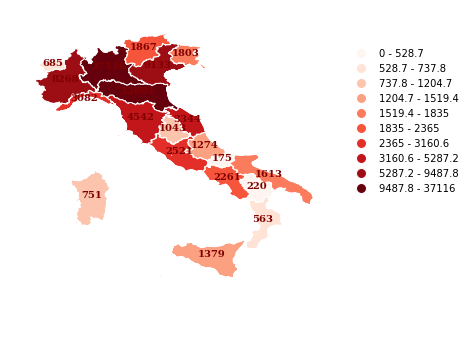

In [164]:
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt


schema = mc.Quantiles(covid19_italy['confirmed'], k=10)
gplt.choropleth(
    covid19_italy,     
    hue='confirmed',     
    edgecolor='white', 
    linewidth=1,
    cmap='Reds',
    scheme=schema,
    legend=True, 
    legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
)

for _, row in covid19_italy.iterrows():
  hue = row['confirmed']
  plt.text(s=row['confirmed'], x = row['coords'][0], y = row['coords'][1],
           horizontalalignment='center', 
           fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'maroon',})